#### Full Code Implementation

In [ ]:
### Load packages and superss warning messages

import pandas as pd
import numpy as np
import re
import sweetviz as sv
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from scikeras.wrappers import KerasClassifier
import shap
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm import tqdm
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # 0 = all messages, 1 = filter INFO, 2 = filter WARNING, 3 = filter ERROR
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

# Download NLTK resources
nltk.download('wordnet')
nltk.download('stopwords')

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

In [4]:
# 1. Load dataset and Performs Data Profiling using Sweetviz
print("Generating Sweetviz report...")
df = pd.read_csv('/Users/IMDB Dataset.csv')
report = sv.analyze(df)
report.show_html('IMDB_sweetviz_report.html')
print("Sweetviz report generated: IMDB_sweetviz_report.html")

Generating Sweetviz report...


                                             |      | [  0%]   00:00 -> (? left)

Report IMDB_sweetviz_report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.
Sweetviz report generated: IMDB_sweetviz_report.html


In [3]:
# 2. Data Preprocessing: Clean, remove stopwords, lemmatize
print("Cleaning and lemmatizing text...")
tqdm.pandas()
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'[^a-z\s]', '', text)
    words = text.split()
    words = [lemmatizer.lemmatize(w) for w in words if w not in stop_words]
    return ' '.join(words)

df['review'] = df['review'].progress_apply(clean_text)
df['sentiment'] = df['sentiment'].map({'positive': 1, 'negative': 0}) # map outputs accordingly : 1 for positive reviews and 0 for negative reviews


Cleaning and lemmatizing text...


100%|███████████████████████████████████| 50000/50000 [00:28<00:00, 1769.01it/s]


In [4]:
# 3. Subsample for grid search (for speed, use more for more robust results)
print("Subsampling data for grid search...")
df_sub = df.sample(n=25000, random_state=42)
X = df_sub['review']
y = df_sub['sentiment']

Subsampling data for grid search...


In [5]:
# 4. Train-test split
print("Splitting data into train and test sets...")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

Splitting data into train and test sets...


In [6]:
# 5. TF-IDF vectorization with limited vocabulary
print("Vectorizing text with TF-IDF...")
vectorizer = TfidfVectorizer(
    max_features=5000, 
    ngram_range=(1,2), 
    stop_words='english'  # Extra safety, but already removed in clean_text
)
X_train_vec = vectorizer.fit_transform(tqdm(X_train, desc="Fitting TF-IDF"))
X_test_vec = vectorizer.transform(tqdm(X_test, desc="Transforming TF-IDF"))

input_dim = X_train_vec.shape[1]


Vectorizing text with TF-IDF...


Transforming TF-IDF: 100%|████████████████| 5000/5000 [00:00<00:00, 6696.27it/s]


In [7]:
# 6. Model builder for scikeras using default values - this will be later overwritten by the grid search defined on cells below
def create_model(units=64, dropout_rate=0.5, learning_rate=0.001, activation='relu'):
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(input_dim,)),
        tf.keras.layers.Dense(units, activation=activation),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [8]:
# 7. Advanced Grid Search - comparing output of model on training dataset using mulitple parameter combination: fine tuning model
print("Starting grid search (grab some tea, coffee, go for a walk, take a nap (?) -> this may take a while)...")
keras_clf = KerasClassifier(
    model=create_model,
    epochs=5,
    batch_size=32,
    verbose=0
)

param_grid = {
    "model__units": [10, 24, 32, 64],
    "model__dropout_rate": [0.1, 0.2, 0.3, 0.5],
    "model__learning_rate": [0.1, 0.25, 0.5, 0.01],
    "model__activation": ['relu', 'tanh'],
    "epochs": [3, 5, 10, 25],
    "batch_size": [10, 32, 64]
}

grid = GridSearchCV(
    estimator=keras_clf,
    param_grid=param_grid,
    cv=3,
    n_jobs=-1,
    scoring='accuracy',
    return_train_score=True,
    verbose=3  # Show progress of grid search
)
grid_result = grid.fit(X_train_vec.toarray(), y_train)

print("Best parameters found:", grid_result.best_params_)
print("Best cross-validated accuracy:", grid_result.best_score_)


Starting grid search (grab a coffee, this may take a while)...
Fitting 3 folds for each of 1536 candidates, totalling 4608 fits
[CV 2/3] END batch_size=10, epochs=3, model__activation=relu, model__dropout_rate=0.1, model__learning_rate=0.1, model__units=24;, score=(train=0.936, test=0.844) total time=  40.1s
[CV 1/3] END batch_size=10, epochs=3, model__activation=relu, model__dropout_rate=0.1, model__learning_rate=0.25, model__units=24;, score=(train=0.791, test=0.748) total time=  34.1s
[CV 3/3] END batch_size=10, epochs=3, model__activation=relu, model__dropout_rate=0.1, model__learning_rate=0.25, model__units=64;, score=(train=0.851, test=0.805) total time=  37.5s
[CV 2/3] END batch_size=10, epochs=3, model__activation=relu, model__dropout_rate=0.1, model__learning_rate=0.5, model__units=32;, score=(train=0.548, test=0.539) total time=  30.0s
[CV 1/3] END batch_size=10, epochs=3, model__activation=relu, model__dropout_rate=0.1, model__learning_rate=0.01, model__units=24;, score=(tra

/opt/anaconda3/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV 1/3] END batch_size=10, epochs=3, model__activation=relu, model__dropout_rate=0.1, model__learning_rate=0.1, model__units=10;, score=(train=0.943, test=0.844) total time=  36.2s
[CV 2/3] END batch_size=10, epochs=3, model__activation=relu, model__dropout_rate=0.1, model__learning_rate=0.25, model__units=10;, score=(train=0.846, test=0.796) total time=  31.0s
[CV 3/3] END batch_size=10, epochs=3, model__activation=relu, model__dropout_rate=0.1, model__learning_rate=0.25, model__units=24;, score=(train=0.877, test=0.818) total time=  33.9s
[CV 2/3] END batch_size=10, epochs=3, model__activation=relu, model__dropout_rate=0.1, model__learning_rate=0.5, model__units=10;, score=(train=0.501, test=0.501) total time=  27.9s
[CV 2/3] END batch_size=10, epochs=3, model__activation=relu, model__dropout_rate=0.1, model__learning_rate=0.5, model__units=64;, score=(train=0.597, test=0.586) total time=  28.6s
[CV 3/3] END batch_size=10, epochs=3, model__activation=relu, model__dropout_rate=0.1, m

/opt/anaconda3/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best parameters found: {'batch_size': 64, 'epochs': 3, 'model__activation': 'relu', 'model__dropout_rate': 0.5, 'model__learning_rate': 0.01, 'model__units': 10}
Best cross-validated accuracy: 0.8661001093359674


In [9]:
# 8. Performance Visualization
results = pd.DataFrame(grid_result.cv_results_)

# Extract relevant columns for summary
summary_cols = [
    'param_model__units',
    'param_model__dropout_rate',
    'param_model__learning_rate',
    'param_model__activation',
    'param_batch_size',
    'param_epochs',
    'mean_train_score',
    'std_train_score',
    'mean_test_score',
    'std_test_score',
    'rank_test_score'
]

summary_table = results[summary_cols].sort_values('rank_test_score')
summary_table = summary_table.rename(columns={
    'param_model__units': 'Units',
    'param_model__dropout_rate': 'Dropout',
    'param_model__learning_rate': 'Learning Rate',
    'param_model__activation': 'Activation',
    'param_batch_size': 'Batch Size',
    'param_epochs': 'Epochs',
    'mean_train_score': 'Mean Train Acc',
    'std_train_score': 'Std Train Acc',
    'mean_test_score': 'Mean Test Acc',
    'std_test_score': 'Std Test Acc',
    'rank_test_score': 'Rank'
})

In [10]:
# Display the top 10 parameter combinations
from IPython.display import display
print("\nTop 10 Parameter Combinations by Test Accuracy:")
display(summary_table.head(10))


Top 10 Parameter Combinations by Test Accuracy:


,Units,Dropout,Learning Rate,Activation,Batch Size,Epochs,Mean Train Acc,Std Train Acc,Mean Test Acc,Std Test Acc,Rank
1084,10,0.5,0.01,relu,64,3,0.964275,0.001649,0.86610,0.001712,1
573,24,0.5,0.01,relu,32,3,0.974300,0.001134,0.86525,0.001709,2
1085,24,0.5,0.01,relu,64,3,0.973725,0.000922,0.86320,0.004894,3
1212,10,0.5,0.01,relu,64,5,0.977200,0.000221,0.86310,0.003747,4
574,32,0.5,0.01,relu,32,3,0.977925,0.000514,0.86305,0.002816,5
1086,32,0.5,0.01,relu,64,3,0.977450,0.000832,0.86295,0.004138,6
61,24,0.5,0.01,relu,10,3,0.969300,0.000871,0.86250,0.004713,7
556,10,0.3,0.01,relu,32,3,0.976500,0.000555,0.86215,0.002751,8
1068,10,0.3,0.01,relu,64,3,0.975400,0.000800,0.86190,0.005326,9
1213,24,0.5,0.01,relu,64,5,0.988825,0.000382,0.86180,0.004070,10


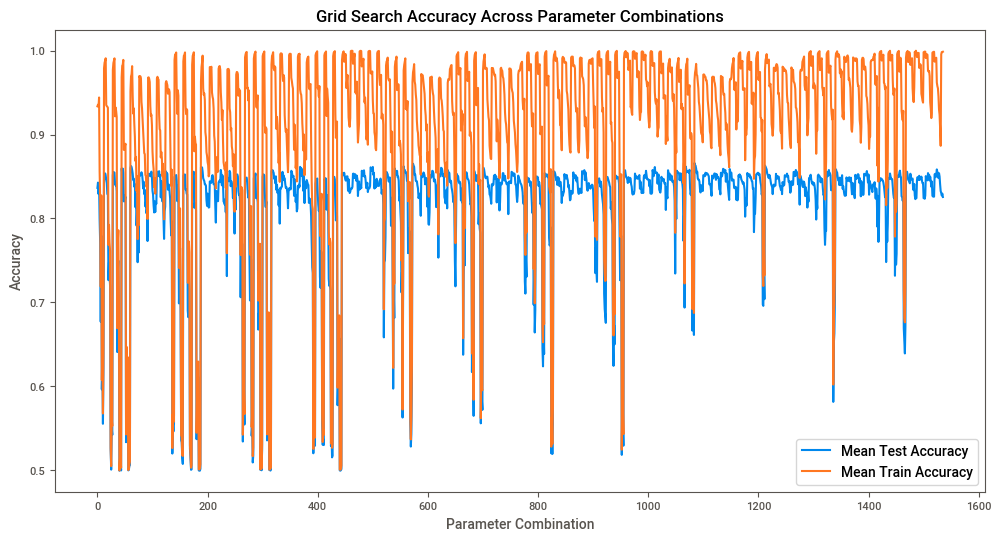

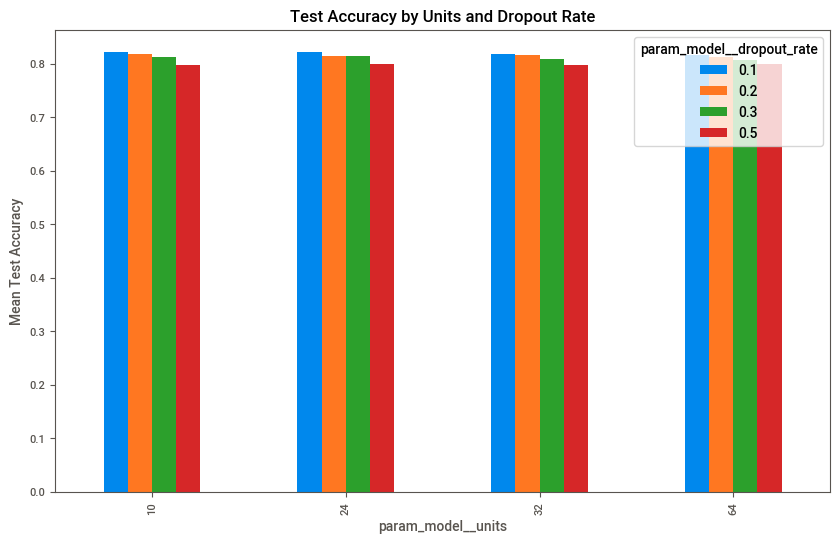

In [11]:
# 9. Performance Visualisation os Model Fine Tuning and Parameterisation
plt.figure(figsize=(12,6))
plt.plot(results['mean_test_score'], label='Mean Test Accuracy')
plt.plot(results['mean_train_score'], label='Mean Train Accuracy')
plt.xlabel('Parameter Combination')
plt.ylabel('Accuracy')
plt.title('Grid Search Accuracy Across Parameter Combinations')
plt.legend()
plt.show()

pivot = results.pivot_table(index='param_model__units', columns='param_model__dropout_rate', values='mean_test_score')
pivot.plot(kind='bar', figsize=(10,6))
plt.title('Test Accuracy by Units and Dropout Rate')
plt.ylabel('Mean Test Accuracy')
plt.show()

In [12]:
# 10. Retrain Final Model with Best Parameters
print("Retraining final model with best parameters on full training data...")
best_params = grid_result.best_params_
final_model = KerasClassifier(
    model=create_model,
    model__units=best_params['model__units'],
    model__dropout_rate=best_params['model__dropout_rate'],
    model__learning_rate=best_params['model__learning_rate'],
    model__activation=best_params['model__activation'],
    epochs=best_params['epochs'],
    batch_size=best_params['batch_size'],
    verbose=1  # Show training progress
)
final_model.fit(X_train_vec.toarray(), y_train)

Retraining final model with best parameters on full training data...
Epoch 1/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.7629 - loss: 0.4854
Epoch 2/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8894 - loss: 0.2799
Epoch 3/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9131 - loss: 0.2218


KerasClassifier(
	model=<function create_model at 0x1522680e0>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=rmsprop
	loss=None
	metrics=None
	batch_size=64
	validation_batch_size=None
	verbose=1
	callbacks=None
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=3
	model__units=10
	model__dropout_rate=0.5
	model__learning_rate=0.01
	model__activation=relu
	class_weight=None
)

In [16]:
# 11. Evaluate Final Model on Test Set
y_pred = final_model.predict(X_test_vec.toarray())
y_proba = final_model.predict_proba(X_test_vec.toarray())
if y_proba.shape[1] == 1:
    y_proba = y_proba.ravel()
elif y_proba.shape[1] == 2:
    y_proba = y_proba[:, 1]

print("\nFinal Model Performance on Test Set:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("Test ROC AUC:", roc_auc_score(y_test, y_proba))

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Final Model Performance on Test Set:
              precision    recall  f1-score   support

           0       0.89      0.82      0.85      2497
           1       0.83      0.90      0.87      2503

    accuracy                           0.86      5000
   macro avg       0.86      0.86      0.86      5000
weighted avg       0.86      0.86      0.86      5000

Confusion Matrix:
 [[2043  454]
 [ 245 2258]]
Test Accuracy: 0.8602
Test ROC AUC: 0.9419965564750412


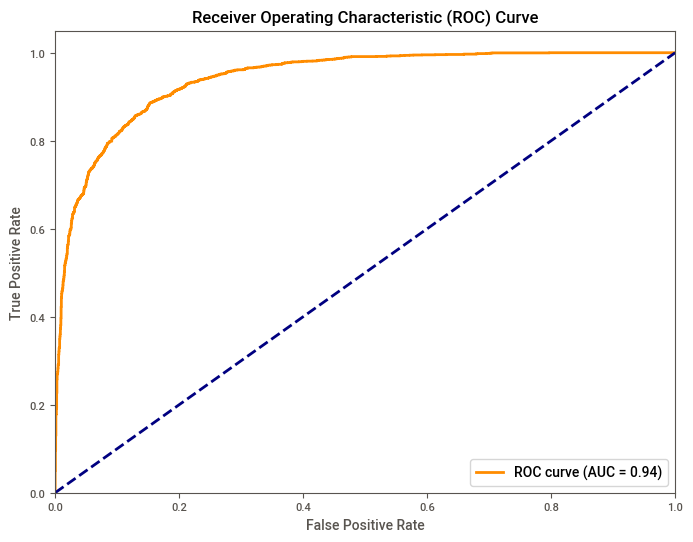

In [18]:
# 12. ROC Curve
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

Running SHAP analysis (this may take a while)...
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/10 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


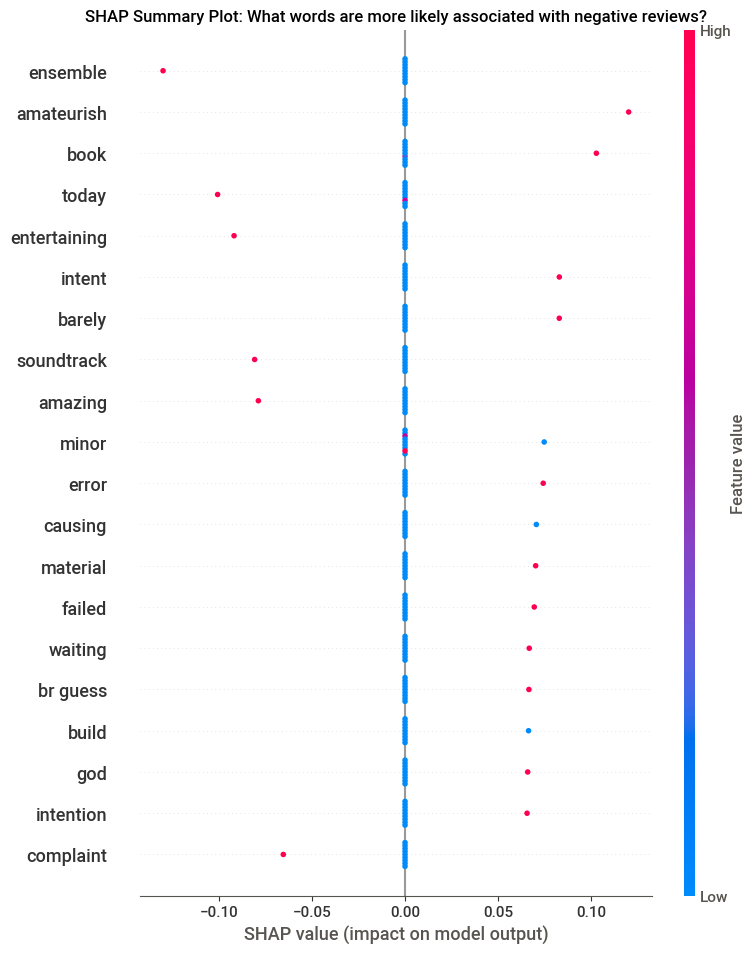

In [19]:
# 13. SHAP analysis for model interpretability
print("Running SHAP analysis (grab some tea, coffee, go for a walk, take a nap (?) -> this may take a while)...")
def proba_positive(x):
    x = np.array(x)
    if x.ndim == 1:
        x = x.reshape(1, -1)
    proba = final_model.predict_proba(x)
    proba = np.atleast_2d(proba)
    return proba[:, 0]  # For sigmoid, output is (n, 1) or (n,)

explainer = shap.KernelExplainer(proba_positive, X_train_vec[:100].toarray())
shap_values = explainer.shap_values(X_test_vec[:10].toarray(), nsamples=1000)

feature_names = vectorizer.get_feature_names_out()
shap.summary_plot(shap_values, X_test_vec[:10].toarray(), feature_names=feature_names, show=False)
plt.title("SHAP Summary Plot: What words are more likely associated with negative reviews?")
plt.show()

In [20]:
### Now we create a syntethic data to evaluate model performance 

import random

positive_starters = [
    "I absolutely loved", "What a fantastic", "An amazing", "A truly wonderful", "Such a great"
]
positive_middles = [
    "experience with this film.", "performance by the cast.", "storyline that kept me engaged.", 
    "direction and cinematography.", "soundtrack and visuals."
]
positive_endings = [
    "Would highly recommend!", "Best movie I've seen in a while.", "It exceeded my expectations.",
    "I would watch it again.", "A must-see for everyone."
]

negative_starters = [
    "I really disliked", "What a terrible", "An awful", "A truly disappointing", "Such a bad"
]
negative_middles = [
    "experience with this film.", "performance by the cast.", "storyline that was boring.", 
    "direction and cinematography.", "soundtrack and visuals."
]
negative_endings = [
    "Would not recommend.", "Worst movie I've seen in a while.", "It did not meet my expectations.",
    "I would not watch it again.", "A waste of time."
]

neutral_fillers = [
    "The movie was released last year.", "I watched it with my friends.", "The theater was crowded.",
    "I had popcorn during the movie.", "It was a long film.", "The actors are well known."
]

def generate_review(starters, middles, endings, fillers, min_sent=2, max_sent=5):
    num_sent = random.randint(min_sent, max_sent)
    review = []
    review.append(random.choice(starters))
    review.append(random.choice(middles))
    review.append(random.choice(endings))
    for _ in range(num_sent - 3):
        review.append(random.choice(fillers))
    random.shuffle(review)
    return " ".join(review)

# Generate 50 positive and 50 negative reviews
random.seed(42)
test_reviews = []
test_labels = []

for _ in range(50):
    test_reviews.append(generate_review(positive_starters, positive_middles, positive_endings, neutral_fillers))
    test_labels.append(1)
for _ in range(50):
    test_reviews.append(generate_review(negative_starters, negative_middles, negative_endings, neutral_fillers))
    test_labels.append(0)

# Shuffle the reviews and labels together
combined = list(zip(test_reviews, test_labels))
random.shuffle(combined)
test_reviews, test_labels = zip(*combined)
test_reviews = list(test_reviews)
test_labels = list(test_labels)

In [21]:
# Clean the reviews
test_reviews_clean = [clean_text(review) for review in test_reviews]

# Vectorize
test_reviews_vec = vectorizer.transform(test_reviews_clean)

In [22]:
# Predict
test_preds = final_model.predict(test_reviews_vec.toarray())
test_proba = final_model.predict_proba(test_reviews_vec.toarray())
if test_proba.shape[1] == 1:
    test_proba = test_proba.ravel()
elif test_proba.shape[1] == 2:
    test_proba = test_proba[:, 1]

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score

print("Performance on Synthetic Reviews:")
print(classification_report(test_labels, test_preds))
print("Confusion Matrix:\n", confusion_matrix(test_labels, test_preds))
print("Accuracy:", accuracy_score(test_labels, test_preds))
print("ROC AUC:", roc_auc_score(test_labels, test_proba))

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Performance on Complex Synthetic Reviews:
              precision    recall  f1-score   support

           0       1.00      0.90      0.95        50
           1       0.91      1.00      0.95        50

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Confusion Matrix:
 [[45  5]
 [ 0 50]]
Accuracy: 0.95
ROC AUC: 0.9996


In [24]:
for i in range(25):
    print(f"Review: {test_reviews[i]}")
    print(f"True label: {test_labels[i]}, Predicted: {test_preds[i]}, Probability: {test_proba[i]:.2f}")
    print("-" * 60)

Review: storyline that kept me engaged. It was a long film. The actors are well known. A must-see for everyone. Such a great
True label: 1, Predicted: 1, Probability: 0.99
------------------------------------------------------------
Review: I had popcorn during the movie. direction and cinematography. An awful It did not meet my expectations.
True label: 0, Predicted: 0, Probability: 0.01
------------------------------------------------------------
Review: Such a great experience with this film. Would highly recommend!
True label: 1, Predicted: 1, Probability: 1.00
------------------------------------------------------------
Review: Would highly recommend! An amazing experience with this film.
True label: 1, Predicted: 1, Probability: 1.00
------------------------------------------------------------
Review: I had popcorn during the movie. experience with this film. The actors are well known. An amazing Would highly recommend!
True label: 1, Predicted: 1, Probability: 1.00
-------------